In [1]:
# coding='utf-8'
import os
import sys
import numpy as np
import time
import datetime
import json
import importlib
import logging
import shutil
import random

import matplotlib
matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib.ticker import NullLocator
# from PIL import Image
import torch
import torch.nn as nn

from yolo_model import yoloModel
from PASCAL_Dataloader import create_split_loaders
from YOLO_Loss import YoloLoss
from utils import NMS, remove_nulls, convert_to_xywh
from detect import plot_detections

%matplotlib inline

In [2]:
config = {}
config["batch_size"] = 16
config['backbone_name'] = "darknet_53"
config['backbone_pretrained'] = ""
config['anchors'] = [[[116, 90], [156, 198], [373, 326]],
                            [[30, 61], [62, 45], [59, 119]],
                            [[10, 13], [16, 30], [33, 23]]]
config['classes'] = 20
config['img_h'] = config['img_w'] = 416
config['confidence_threshold'] = 0.5
config['nms_threshold'] = 0.4

'''
UPDATE THESE VALUES!

'''
config['pretrain_snapshot'] = "./states/20190602203613/model.pth" # "./states/20190530222509/model.pth"
config['root_dir'] = './VOCdevkit/VOC2012'
config['output_dir'] = './detected_images/'

_, _, test_loader = create_split_loaders(batch_size=config['batch_size'])
print('There are %d batches in test set. This only runs the first batch.' %len(test_loader))

There are 130 batches in test set. This only runs the first batch.


In [3]:
def confusion(config, test_loader, output_dir=config['output_dir']):
    
    C = np.zeros( (20, 20) )
    empty_labels = 0
    
    # Load and initialize network
    net = yoloModel(config).cuda()

    # Restore pretrain model
    if config["pretrain_snapshot"]:
        print('Loading model...')
        logging.info("load checkpoint from {}".format(config["pretrain_snapshot"]))
        state_dict = torch.load(config["pretrain_snapshot"])
        net.load_state_dict(state_dict)
    else:
        raise Exception("missing pretrain_snapshot!!!")


    # YOLO loss with 3 scales
    yolo_losses = []
    for i in range(3):
        yolo_losses.append(YoloLoss(config["classes"], (config["img_w"], config["img_h"]), config["anchors"][i]))
        
    # Start inference          
    for batch, sample in enumerate(test_loader):

            
        images, labels = sample["image"], sample["label"]
        orig_W, orig_H = sample["orig_img"][0], sample["orig_img"][1]
        target_labels = sample["target_label"]
        imgfiles = sample["imgfile"]
        
        # Create image pathfiles
        imgpaths = [os.path.join(config["root_dir"], 'JPEGImages', x) for x in imgfiles]
        
        orig_W = orig_W.to('cpu').numpy()
        orig_H = orig_H.to('cpu').numpy()
        images = images.cuda()
        
        # Run images through model, get predictions, and apply NMS.
        with torch.no_grad():
            outputs = net(images)
            output_list = []
            for i in range(3):
                output_list.append(yolo_losses[i](outputs[i]))
            detections = torch.cat(output_list, 1)
            detections = NMS(detections, 20)

        for ii, detection in enumerate(detections): ## 0 to 15
        # ------------------------------------- #
        # Parsing targets and detections labels #
        # ------------------------------------- #
            print('\nbatch %d, sample %d' %(batch,ii))
            targets = convert_to_xywh(remove_nulls(target_labels[ii,:].to('cpu').numpy())) #70x5
            #print('target labels (cls, x, y, w, h)\n', targets)           
            
            if detection is not None:
                # Rescale coordinates to original dimensions
                RATIO_W = orig_W[ii] / config["img_w"]
                RATIO_H = orig_H[ii] / config["img_h"]
            
                predictions = np.zeros((len(detection),5), dtype=int)
                for jj, (x1, y1, x2, y2, conf, cls_conf, cls_pred) in enumerate(detection):        
                    x = int(x1 * RATIO_W)
                    y = int(y1 * RATIO_H)
                    w = int(abs(x2 - x1) * RATIO_W)
                    h = int(abs(y2 - y1) * RATIO_H)
                    predictions[jj,:] = (int(cls_pred), x, y, w, h) 
                    
                    if predictions[jj,0] == targets[:,0].any():
                        C[predictions[jj,0]][predictions[jj,0]] += 1
                    elif predictions[jj,0] != targets[:,0].any():
                        C[predictions[jj,0]][targets[:,0]] += 1
                
            else:
                predictions = []
                empty_labels += 1
            
    return C

C = confusion(config,test_loader)

Loading model...

batch 0, sample 0

batch 0, sample 1

batch 0, sample 2

batch 0, sample 3

batch 0, sample 4

batch 0, sample 5

batch 0, sample 6

batch 0, sample 7

batch 0, sample 8

batch 0, sample 9

batch 0, sample 10

batch 0, sample 11

batch 0, sample 12

batch 0, sample 13

batch 0, sample 14

batch 0, sample 15

batch 1, sample 0

batch 1, sample 1

batch 1, sample 2

batch 1, sample 3

batch 1, sample 4

batch 1, sample 5

batch 1, sample 6

batch 1, sample 7

batch 1, sample 8

batch 1, sample 9

batch 1, sample 10

batch 1, sample 11

batch 1, sample 12

batch 1, sample 13

batch 1, sample 14

batch 1, sample 15

batch 2, sample 0

batch 2, sample 1

batch 2, sample 2

batch 2, sample 3

batch 2, sample 4

batch 2, sample 5

batch 2, sample 6

batch 2, sample 7

batch 2, sample 8

batch 2, sample 9

batch 2, sample 10

batch 2, sample 11

batch 2, sample 12

batch 2, sample 13

batch 2, sample 14

batch 2, sample 15

batch 3, sample 0

batch 3, sample 1

batch 3, sampl


batch 26, sample 0

batch 26, sample 1

batch 26, sample 2

batch 26, sample 3

batch 26, sample 4

batch 26, sample 5

batch 26, sample 6

batch 26, sample 7

batch 26, sample 8

batch 26, sample 9

batch 26, sample 10

batch 26, sample 11

batch 26, sample 12

batch 26, sample 13

batch 26, sample 14

batch 26, sample 15

batch 27, sample 0

batch 27, sample 1

batch 27, sample 2

batch 27, sample 3

batch 27, sample 4

batch 27, sample 5

batch 27, sample 6

batch 27, sample 7

batch 27, sample 8

batch 27, sample 9

batch 27, sample 10

batch 27, sample 11

batch 27, sample 12

batch 27, sample 13

batch 27, sample 14

batch 27, sample 15

batch 28, sample 0

batch 28, sample 1

batch 28, sample 2

batch 28, sample 3

batch 28, sample 4

batch 28, sample 5

batch 28, sample 6

batch 28, sample 7

batch 28, sample 8

batch 28, sample 9

batch 28, sample 10

batch 28, sample 11

batch 28, sample 12

batch 28, sample 13

batch 28, sample 14

batch 28, sample 15

batch 29, sample 0

b


batch 52, sample 0

batch 52, sample 1

batch 52, sample 2

batch 52, sample 3

batch 52, sample 4

batch 52, sample 5

batch 52, sample 6

batch 52, sample 7

batch 52, sample 8

batch 52, sample 9

batch 52, sample 10

batch 52, sample 11

batch 52, sample 12

batch 52, sample 13

batch 52, sample 14

batch 52, sample 15

batch 53, sample 0

batch 53, sample 1

batch 53, sample 2

batch 53, sample 3

batch 53, sample 4

batch 53, sample 5

batch 53, sample 6

batch 53, sample 7

batch 53, sample 8

batch 53, sample 9

batch 53, sample 10

batch 53, sample 11

batch 53, sample 12

batch 53, sample 13

batch 53, sample 14

batch 53, sample 15

batch 54, sample 0

batch 54, sample 1

batch 54, sample 2

batch 54, sample 3

batch 54, sample 4

batch 54, sample 5

batch 54, sample 6

batch 54, sample 7

batch 54, sample 8

batch 54, sample 9

batch 54, sample 10

batch 54, sample 11

batch 54, sample 12

batch 54, sample 13

batch 54, sample 14

batch 54, sample 15

batch 55, sample 0

b


batch 78, sample 0

batch 78, sample 1

batch 78, sample 2

batch 78, sample 3

batch 78, sample 4

batch 78, sample 5

batch 78, sample 6

batch 78, sample 7

batch 78, sample 8

batch 78, sample 9

batch 78, sample 10

batch 78, sample 11

batch 78, sample 12

batch 78, sample 13

batch 78, sample 14

batch 78, sample 15

batch 79, sample 0

batch 79, sample 1

batch 79, sample 2

batch 79, sample 3

batch 79, sample 4

batch 79, sample 5

batch 79, sample 6

batch 79, sample 7

batch 79, sample 8

batch 79, sample 9

batch 79, sample 10

batch 79, sample 11

batch 79, sample 12

batch 79, sample 13

batch 79, sample 14

batch 79, sample 15

batch 80, sample 0

batch 80, sample 1

batch 80, sample 2

batch 80, sample 3

batch 80, sample 4

batch 80, sample 5

batch 80, sample 6

batch 80, sample 7

batch 80, sample 8

batch 80, sample 9

batch 80, sample 10

batch 80, sample 11

batch 80, sample 12

batch 80, sample 13

batch 80, sample 14

batch 80, sample 15

batch 81, sample 0

b


batch 103, sample 0

batch 103, sample 1

batch 103, sample 2

batch 103, sample 3

batch 103, sample 4

batch 103, sample 5

batch 103, sample 6

batch 103, sample 7

batch 103, sample 8

batch 103, sample 9

batch 103, sample 10

batch 103, sample 11

batch 103, sample 12

batch 103, sample 13

batch 103, sample 14

batch 103, sample 15

batch 104, sample 0

batch 104, sample 1

batch 104, sample 2

batch 104, sample 3

batch 104, sample 4

batch 104, sample 5

batch 104, sample 6

batch 104, sample 7

batch 104, sample 8

batch 104, sample 9

batch 104, sample 10

batch 104, sample 11

batch 104, sample 12

batch 104, sample 13

batch 104, sample 14

batch 104, sample 15

batch 105, sample 0

batch 105, sample 1

batch 105, sample 2

batch 105, sample 3

batch 105, sample 4

batch 105, sample 5

batch 105, sample 6

batch 105, sample 7

batch 105, sample 8

batch 105, sample 9

batch 105, sample 10

batch 105, sample 11

batch 105, sample 12

batch 105, sample 13

batch 105, sample


batch 127, sample 0

batch 127, sample 1

batch 127, sample 2

batch 127, sample 3

batch 127, sample 4

batch 127, sample 5

batch 127, sample 6

batch 127, sample 7

batch 127, sample 8

batch 127, sample 9

batch 127, sample 10

batch 127, sample 11

batch 127, sample 12

batch 127, sample 13

batch 127, sample 14

batch 127, sample 15

batch 128, sample 0

batch 128, sample 1

batch 128, sample 2

batch 128, sample 3

batch 128, sample 4

batch 128, sample 5

batch 128, sample 6

batch 128, sample 7

batch 128, sample 8

batch 128, sample 9

batch 128, sample 10

batch 128, sample 11

batch 128, sample 12

batch 128, sample 13

batch 128, sample 14

batch 128, sample 15

batch 129, sample 0

batch 129, sample 1

batch 129, sample 2

batch 129, sample 3

batch 129, sample 4

batch 129, sample 5

batch 129, sample 6

batch 129, sample 7

batch 129, sample 8

batch 129, sample 9

batch 129, sample 10

batch 129, sample 11

batch 129, sample 12


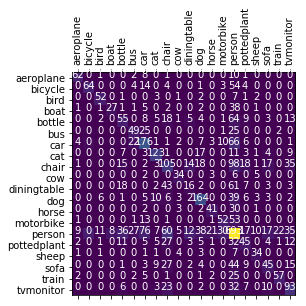

In [6]:
import matplotlib.pyplot as plt
plt.matshow( C )
objects = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", \
                        "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", \
                        "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
tick_marks = np.arange( len( objects  ) )

for i in range( 20 ):
    for j in range( 20 ):
            plt.text(i, j, int(C[i][j]), horizontalalignment="center", color="white")

plt.xticks(tick_marks, objects, rotation=90)
plt.yticks(tick_marks, objects)
plt.show()